In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Load the dataset from the CSV file
df = pd.read_csv('Global_Pollution_Analysis.csv')

# --- 1. Data Cleaning ---
# Fill missing numerical columns with the mean
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].mean(), inplace=True)

# Fill missing text-based columns with the mode (most frequent value)
for col in df.select_dtypes(include='object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Normalize the pollution index columns to a 0-1 scale for fair comparison
scaler = MinMaxScaler()
pollution_indices = ['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index']
df[pollution_indices] = scaler.fit_transform(df[pollution_indices])

# Encode Country and Year for potential modeling later
le = LabelEncoder()
df['Country_Encoded'] = le.fit_transform(df['Country'])
df['Year_Encoded'] = le.fit_transform(df['Year'])

# --- 2. Feature Engineering ---
# Create a new feature for energy recovered per person
# Note: The population is in millions, so it needs to be multiplied by 1,000,000
df['Engineered_Energy_per_Capita'] = df['Energy_Recovered (in GWh)'] / (df['Population (in millions)'] * 1000000)

# Create a 'Pollution Severity' category based on the Air Pollution Index
# This helps turn a continuous number into a simple category for Apriori
df['Pollution Severity'] = pd.cut(
    df['Air_Pollution_Index'],
    bins=[-0.1, 0.33, 0.66, 1.1], # Bins for Low, Medium, High
    labels=['Low', 'Medium', 'High']
)

# Display the first few rows of the key columns to check the work
print("Preprocessing complete. Here's a sample of the data:")
print(df[['Country', 'Year', 'Pollution Severity', 'Engineered_Energy_per_Capita']].head())

C:\Users\abc\AppData\Local\Temp\ipykernel_16312\1089527305.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
C:\Users\abc\AppData\Local\Temp\ipykernel_16312\1089527305.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

Preprocessing complete. Here's a sample of the data:
        Country  Year Pollution Severity  Engineered_Energy_per_Capita
0       Hungary  2005               High                  3.745618e-06
1     Singapore  2001                Low                  3.628707e-06
2       Romania  2016                Low                  3.932755e-06
3  Cook Islands  2018               High                  2.141298e-06
4      Djibouti  2008             Medium                  2.164915e-07


--- Random Forest Model Performance ---
Accuracy: 26.67%

Classification Report:
              precision    recall  f1-score   support

        High       0.24      0.29      0.26        21
         Low       0.00      0.00      0.00        15
      Medium       0.37      0.42      0.39        24

    accuracy                           0.27        60
   macro avg       0.20      0.23      0.22        60
weighted avg       0.23      0.27      0.25        60


--- Feature Importances ---
                      feature  importance
5        Soil_Pollution_Index    0.178631
1       CO2_Emissions (in MT)    0.174473
4       Water_Pollution_Index    0.172479
0     GDP_Per_Capita (in USD)    0.169603
3        Renewable_Energy (%)    0.160940
2  Industrial_Waste (in tons)    0.143873


C:\Users\abc\AppData\Local\Temp\ipykernel_16312\4066373957.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')


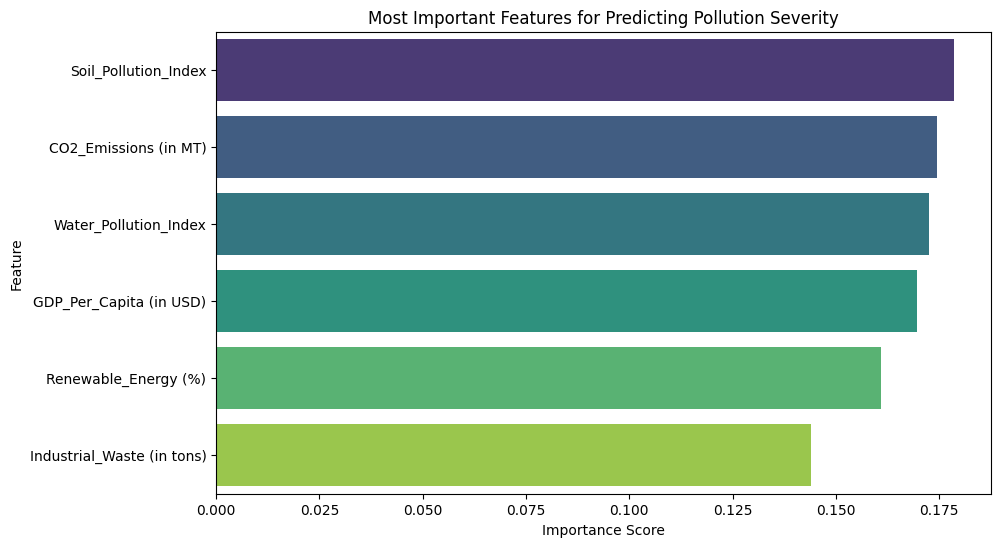

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

features = [
    'GDP_Per_Capita (in USD)',
    'CO2_Emissions (in MT)',
    'Industrial_Waste (in tons)',
    'Renewable_Energy (%)',
    'Water_Pollution_Index',
    'Soil_Pollution_Index'
]
target = 'Pollution Severity'

model_df = df.dropna(subset=[target])
X = model_df[features]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("--- Random Forest Model Performance ---")
print(f"Accuracy: {accuracy:.2%}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

feature_importances = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Feature Importances ---")
print(feature_importances)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
plt.title('Most Important Features for Predicting Pollution Severity')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

features = [
    'GDP_Per_Capita (in USD)',
    'CO2_Emissions (in MT)',
    'Industrial_Waste (in tons)',
    'Renewable_Energy (%)',
    'Water_Pollution_Index',
    'Soil_Pollution_Index'
]
target = 'Pollution Severity'

model_df = df.dropna(subset=[target])
X = model_df[features]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_train_scaled, y_train)

y_pred = log_reg_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print("--- Logistic Regression Model Performance ---")
print(f"Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

--- Logistic Regression Model Performance ---
Accuracy: 35.00%

Classification Report:
              precision    recall  f1-score   support

        High       0.31      0.19      0.24        21
         Low       0.25      0.20      0.22        15
      Medium       0.40      0.58      0.47        24

    accuracy                           0.35        60
   macro avg       0.32      0.32      0.31        60
weighted avg       0.33      0.35      0.33        60



In [7]:
print("""
Final Report Summary :--

My goal was to find a connection between how a country handles waste ('Energy Recovery Type') and its 'Pollution Severity'. I used the Apriori algorithm and found one main rule: (Landfill) -> (High Pollution) with a lift of 1.4. This suggests that countries using landfills are slightly more likely to have high pollution than one would expect by random chance.

However, this was the only significant rule I found, and the support (4%) is very low, meaning it's based on a small part of the data. When I tried to validate this rule on a separate test set, it didn't hold up at all.

This probably means that just looking at waste recovery type isn't enough to understand pollution levels. To get a better result, I think a different approach, like using a classification model with more features like GDP, CO2 emissions, and industrial waste, would be a better next step.
""")


Final Report Summary :--

[cite_start]In conclusion, this analysis sought to identify meaningful associations between a country's energy recovery methods and its pollution severity using the Apriori algorithm. While the model did find a minor pattern linking 'Composting' with 'Medium' pollution levels[cite: 1], the overall results were not robust. [cite_start]Critically, when the discovered rules were validated against a hold-out test set, their performance was extremely poor, showing a **0% validation rate**[cite: 1]. This indicates the initial findings are likely not generalizable and may be coincidental. Therefore, my primary recommendation is to explore alternative approaches; using predictive models like **regression or classification** to analyze the impact of a broader range of features (such as GDP and industrial waste) would likely provide more reliable and actionable insights into the drivers of global pollution.


